In [ ]:
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix

import h5py
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.metrics import Metric
from tensorflow.keras import optimizers,regularizers
from keras.models import load_model

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = h5py.File('/content/drive/My Drive/Colab Notebooks/SVHN_single_grey1.h5','r')
df.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [ ]:
x_train = df['X_train'][:]
y_train = df['y_train'][:]

x_test = df['X_test'][:]
y_test = df['y_test'][:]

# Understanding and visualizing the data

In [ ]:
print("Shape of train set: "+str(x_train.shape))
print("Corresponding train set labels: "+str(y_train.shape))

print("")

print("Shape of test set: "+str(x_test.shape))
print("Corresponding test set labels: "+str(y_test.shape))

Shape of train set: (42000, 32, 32)
Corresponding train set labels: (42000,)

Shape of test set: (18000, 32, 32)
Corresponding test set labels: (18000,)


The images are labelled from 0 to 9. There are 10 unique labels and the train set is balanced.
We have around 4000 samples for each class.


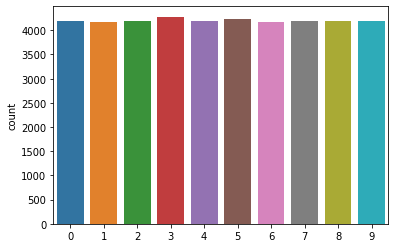

In [ ]:
sns.countplot(x=pd.Series(y_train))
print("The images are labelled from 0 to 9. There are 10 unique labels and the train set is balanced.")
print("We have around 4000 samples for each class.")

The images are labelled from 0 to 9. There are 10 unique labels and the test set is also balanced.
We have around 1750 samples for each class.


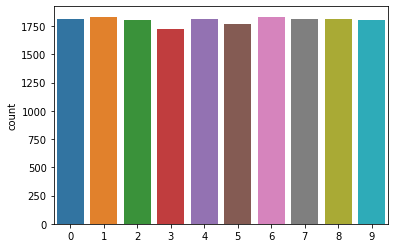

In [ ]:
sns.countplot(x=pd.Series(y_test))
print("The images are labelled from 0 to 9. There are 10 unique labels and the test set is also balanced.")
print("We have around 1750 samples for each class.")

so we have 42000 images each of 32x32 pixels in training set and 18000 images each of 32x32 pixels in testing set
<br>

Lets see the range of the pixels in both test and train set  

In [ ]:
print("train set range:")
print(x_train.min())
print(x_train.max())

print("test set range:")
print(x_train.min())
print(x_train.max())

print("")
print("So the pixels lie between 0-255 i.e grey scale images")

train set range:
0.0
254.9745
test set range:
0.0
254.9745

So the pixels lie between 0-255 i.e grey scale images


**Lets visualize first 10 images and their labels**

image 1, labelled as 2 
image 2, labelled as 6 
image 3, labelled as 7 
image 4, labelled as 4 
image 5, labelled as 4 
image 6, labelled as 0 
image 7, labelled as 3 
image 8, labelled as 0 
image 9, labelled as 7 
image 10, labelled as 3 


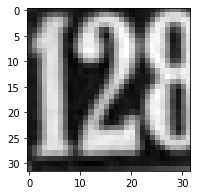

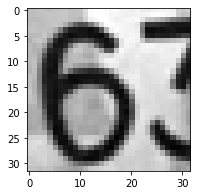

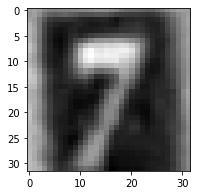

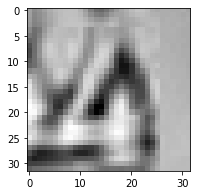

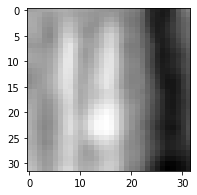

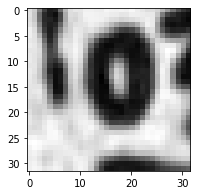

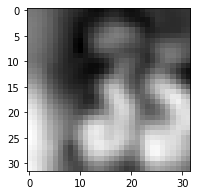

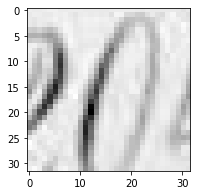

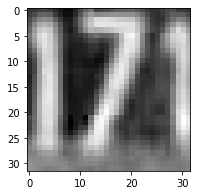

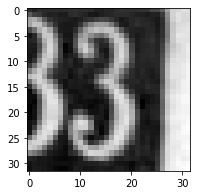

In [ ]:
for i in range(10):
    image = x_train[i]
    print("image {0}, labelled as {1} ".format(i+1,y_train[i]))
    plt.figure(i,figsize=(7,3))
    plt.imshow(image,cmap='gray')

# Reshaping and normalizing the data

In [ ]:
# flattening feature set
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)

# one-hot encoding target/labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("train set after reshaping: "+str(x_train.shape))
print("train set labels after reshaping: "+str(y_train.shape))

print("test set after reshaping: "+str(x_test.shape))
print("test set labels after reshaping: "+str(y_test.shape))

train set after reshaping: (42000, 1024)
train set labels after reshaping: (42000, 10)
test set after reshaping: (18000, 1024)
test set labels after reshaping: (18000, 10)


We have seen these first 10 labels above



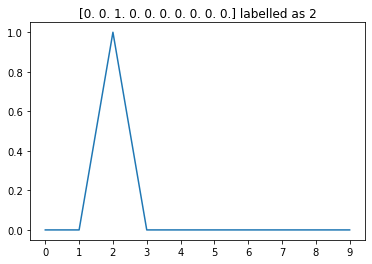

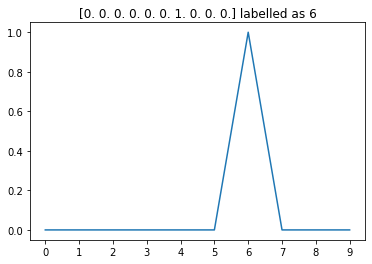

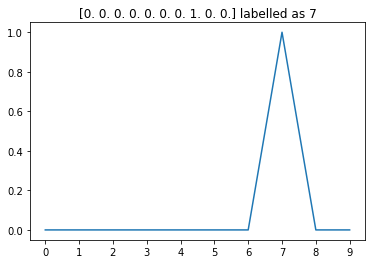

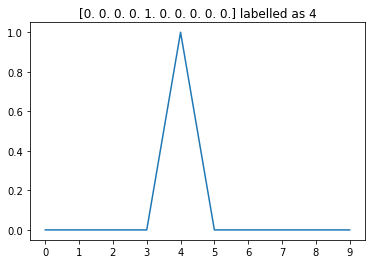

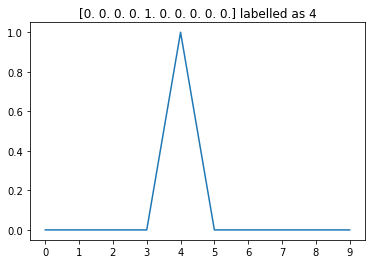

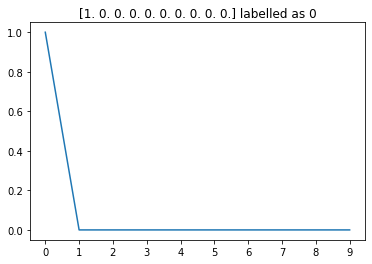

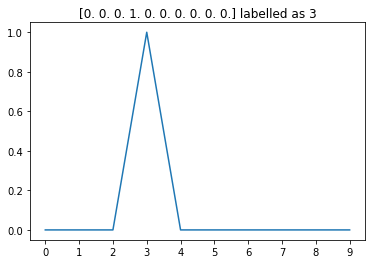

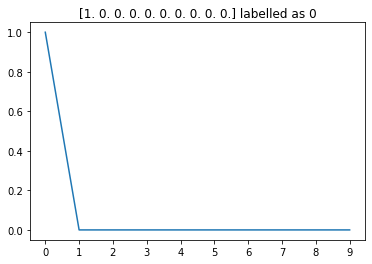

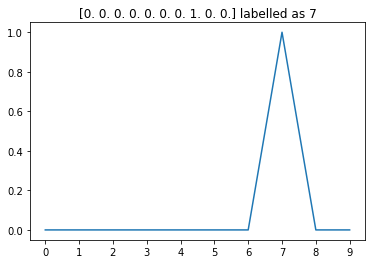

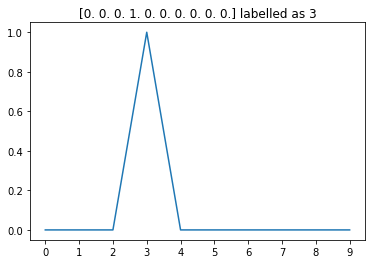

In [ ]:
print("We have seen these first 10 labels above")
print("")
for i in range(10):
  plt.title("{0} labelled as {1}".format(y_train[i],y_train[i].argmax()))
  plt.plot(y_train[i]) 
  plt.xticks(range(10))
  plt.show()

**Now that we have reshaped data, lets see how our inputs look like. Plotting 1st 10 inputs**

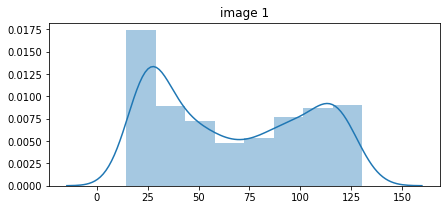

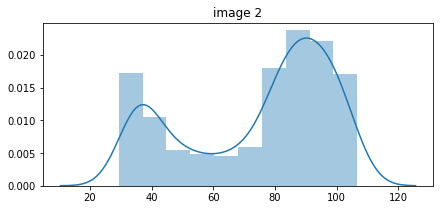

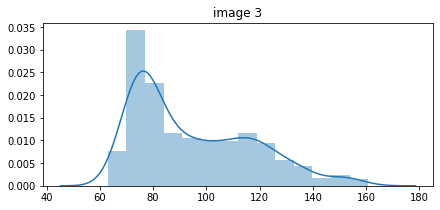

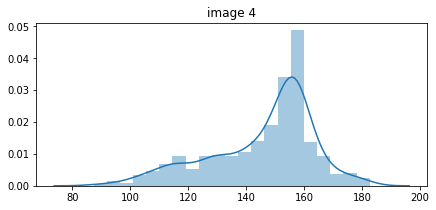

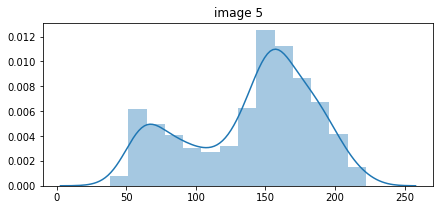

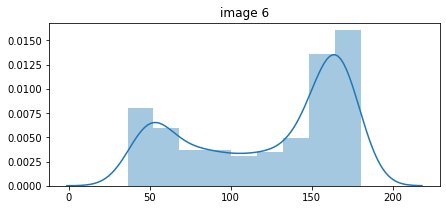

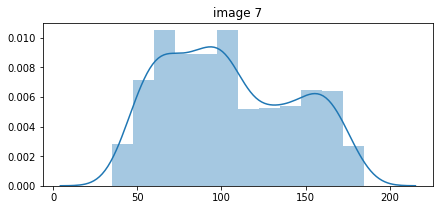

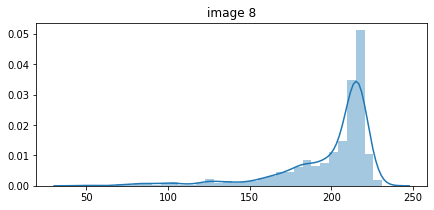

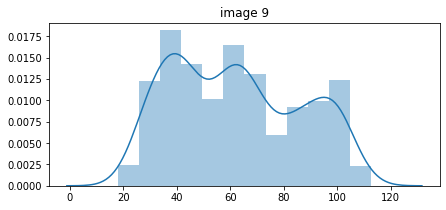

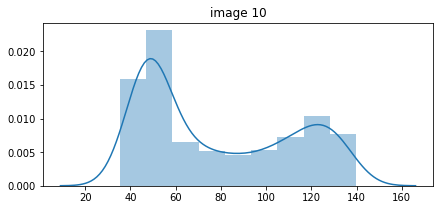

In [ ]:
for i in range(10):
  plt.figure(i,figsize=(7,3))
  plt.title("image {}".format(i+1))
  plot = sns.distplot(x_train[i])

As we can see that our inputs are not normalized. We should normalize the inputs but instead of doing it beforehand we will batch normalize it in the model itself. We shall see it in detail but just to give a gist of it, we will create an input vector of 1024 units/neurons, which will go into the batch normalization layer and then go for further processing.<br>
**input -> batchnormalize -> .......... -> output** 

# Lets define the architecture of our neural network

In [ ]:
def plot_graph(loss,acc,epochs):
    
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
    axes[0].plot(range(0,epochs), loss, label="train loss")
    axes[1].plot(range(0,epochs), acc, label="train acc")
    axes[0].legend()
    axes[1].legend()
    figure.show()
    plt.tight_layout()

In [ ]:
def model1(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False):

  model = tensorflow.keras.models.Sequential()

  #adding input layer with batch normalisation - input shape=1024 (1024 dimensions after flattening)
  model.add(tensorflow.keras.layers.BatchNormalization(input_shape=(1024,), name="input_with_batchnorm_layer"))

  #adding 1st layer
  model.add(Dense(700, name="h1_relu", activation='relu'))

  #adding 2nd layer
  model.add(Dense(700, name="h2_relu", activation='relu'))

  #adding 3rd layer
  model.add(Dense(700, name="h3_relu", activation='relu'))

  #adding 4th layer
  model.add(Dense(700, name="h4_relu", activation='relu'))

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, activation='softmax', name="output_layer_softmax", kernel_regularizer=regularizers.l2(l2_lambda)))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
  else:
    val=None
  
  model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, verbose=1)

  if(save_model_name!=False):
    model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
  
  return model



**Sanity checking: Lets see if the loss is reasonable. Disabling the regularisation and keeping the learning rate too low**

In [ ]:
model = model1(xtrain=x_train, ytrain=y_train, epoch=1, batchsize=16, learn_rate=0.00001, l2_lambda=0)

2625/2625 [==============================] - 51s 19ms/step - loss: 2.0138 - accuracy: 0.3261


So basically in the very first epoch we randomly assign weights and since its the 1st epoch, we are not using the uppdated weights as they will be used in the next epoch. Due to random weights the probabilty of output for each class would be same. We have 10 classes/labels in the target variable therefore probabilty at each output neuron would be 1/10=0.1 approx.
Now, lets say that our input image was 7 hence the output neuron of 7 will be 0.1(all output neurons are 0.1). So the loggloss/cross entropy loss will be -log(0.1) = 2.3025 approx.
Our loss is 2.1085 therefore we can say that it is reasonable. This is our first sanity check.
<br><br>
**Lets crank up the lamda and do the same:**

In [ ]:
model = model1(xtrain=x_train, ytrain=y_train, epoch=1, batchsize=16, learn_rate=0.00001, l2_lambda=1000)

2625/2625 [==============================] - 15s 6ms/step - loss: 12927.0479 - accuracy: 0.3211


As expected the loss is too high. Thats another sanity check.<br><br>**Lets try to overfit the model on a small subset of train set without regularisation and a reasonable learning rate this time. It will give us a good idea about any changes required in the architecture.**

In [ ]:
model = model1(xtrain=x_train[0:20], ytrain=y_train[0:20], epoch=500, batchsize=5, learn_rate=0.001, l2_lambda=0)

Epoch 1/500
4/4 [==============================] - 0s 5ms/step - loss: 3.0838 - accuracy: 0.1000
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 1.3356 - accuracy: 0.6000
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 1.2245 - accuracy: 0.6500
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 1.2814 - accuracy: 0.5500
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.9632 - accuracy: 0.7500
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 0.5102 - accuracy: 0.8500
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.5254 - accuracy: 0.8000
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2980 - accuracy: 0.9000
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.7500
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 1.1111 - accuracy: 0.8500
Epoch 11/500
4/4 [===========

We are able to overfit this small subset of training set. The model architecture looks fine. Lets see what the architecture looks like:

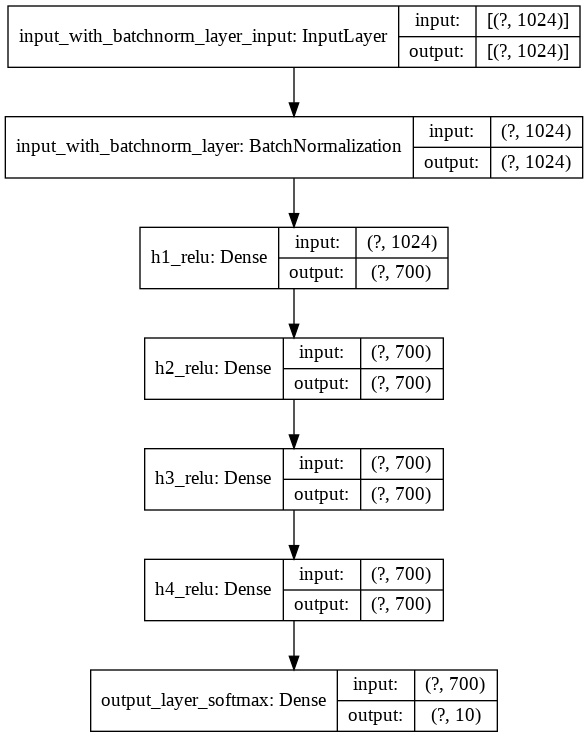

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

Therefore, we have a input layer followed by batch normalization which takes an input vector of size 1024 and gives an output vector of size 1024 after normalizing.<br> This normalized input Then goes to the 1st hidden layer having 700 neurons(relu activation function) --> then 2nd layer having 700 neurons(relu activation function) --> then 3rd hidden layers with 700 neurons(relu activation function) --> then 4th layer having 700 neurons(relu activation function) --> Finally, it goes to the final output layer with softmax layer that gives out the probabilities of belonging to the each of the classes in the target variable(in our case 10 i.e 10 neurons).<br><br>
**Now that we have overfitted the network on a small subset of 20 images and done some sanity checking, lets train the model on the whole training set and evaluate it on the testing set. We will then improve upon the architecture as we progress further.<br> We will train the model for 100 epochs with a batch size of 10 i.e 42000/10 = 4200 samples per epoch. We will then evaluate this model on the test set of 18000 samples.<br> We are starting off with a learning rate and l2 regularization of 0.0001.**

In [ ]:
model_1 = model1(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=10, learn_rate=0.0001, l2_lambda=0.0001, save_model_name="model_1")

Epoch 1/100
4200/4200 [==============================] - 24s 6ms/step - loss: 1.4276 - accuracy: 0.5208
Epoch 2/100
4200/4200 [==============================] - 24s 6ms/step - loss: 1.0714 - accuracy: 0.6517
Epoch 3/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.9749 - accuracy: 0.6883
Epoch 4/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.9130 - accuracy: 0.7036
Epoch 5/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.8673 - accuracy: 0.7198
Epoch 6/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.8223 - accuracy: 0.7348
Epoch 7/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7965 - accuracy: 0.7417
Epoch 8/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7706 - accuracy: 0.7500
Epoch 9/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7404 - accuracy: 0.7595
Epoch 10/100
4200/4200 [==============================] - 24s 6m

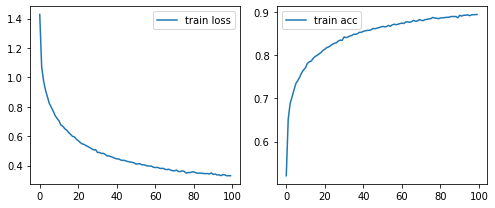

In [ ]:
loss = model_1.history.history['loss']
acc = model_1.history.history['accuracy']
plot_graph(loss,acc,epochs=100)

In [ ]:
model_1.evaluate(x_test, y_test,batch_size=10)

1800/1800 [==============================] - 6s 3ms/step - loss: 0.6435 - accuracy: 0.8704


[0.6434842944145203, 0.8704444169998169]

**lets see how we can improve the model further:**<br>
We know that weight initialisation plays a critical role. With the right weight initialization method can speed up the convergence remarkably. Empirically it is found that Relu works best with He initialization (xavier/2 initialization). Currently, the default kernel_initializer is glorot_uniform_initializer which is nothing but xavier uniform initializer. So we will add he_normal initialization in all the layers. Everything else remains same.

In [ ]:
def model2(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False, ver_bose=True):

  model = tensorflow.keras.models.Sequential()

  #adding input layer with batch normalisation - input shape=1024 (1024 dimensions after flattening) - with he_normal initialization
  model.add(tensorflow.keras.layers.BatchNormalization(input_shape=(1024,), gamma_initializer='he_normal', name="input_with_batchnorm_layer"))

  #adding 1st layer with he_normal initialization
  model.add(Dense(700, name="h1_relu", kernel_initializer='he_normal', activation='relu'))

  #adding 2nd layer with he_normal initialization
  model.add(Dense(700, name="h2_relu", kernel_initializer='he_normal', activation='relu'))

  #adding 3rd layer with he_normal initialization
  model.add(Dense(700, name="h3_relu", kernel_initializer='he_normal', activation='relu'))

  #adding 4th layer with he_normal initialization
  model.add(Dense(700, name="h4_relu", kernel_initializer='he_normal', activation='relu'))
  # model.add(BatchNormalization())

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, activation='softmax', kernel_initializer='he_normal', name="output_layer_softmax", kernel_regularizer=regularizers.l2(l2_lambda)))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
  else:
    val=None
  
  if(ver_bose!=True):
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, verbose=0)
    print("model has been fitted.. evaluating on train and test set")
    score_train = model.evaluate(xtrain, ytrain, batch_size=32, verbose=0)
    score_test = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")

    return [model,score_train,score_test]
  else:
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, verbose=1)
    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
    
    return model



In [ ]:
model_2 = model2(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=10, learn_rate=0.0001, l2_lambda=0.0001, save_model_name="model_2")

Epoch 1/100
4200/4200 [==============================] - 24s 6ms/step - loss: 1.4420 - accuracy: 0.5148
Epoch 2/100
4200/4200 [==============================] - 24s 6ms/step - loss: 1.0325 - accuracy: 0.6686
Epoch 3/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.9271 - accuracy: 0.7004
Epoch 4/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.8586 - accuracy: 0.7243
Epoch 5/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.8206 - accuracy: 0.7365
Epoch 6/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7886 - accuracy: 0.7430
Epoch 7/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7515 - accuracy: 0.7573
Epoch 8/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7343 - accuracy: 0.7641
Epoch 9/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7170 - accuracy: 0.7682
Epoch 10/100
4200/4200 [==============================] - 24s 6m

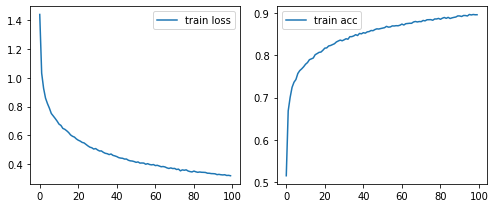

In [ ]:
loss = model_2.history.history['loss']
acc = model_2.history.history['accuracy']

plot_graph(loss,acc,epochs=100)

In [ ]:
model_2.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 5s 3ms/step - loss: 0.5276 - accuracy: 0.8775


[0.5276171565055847, 0.8774999976158142]

There is a slight improvement after adding he_normal initialization. Test accuracy increased from 0.8704 to 0.8775 and test loss decreased from 0.6435 to 0.5276. <br><br>**Lets explore the learning rate here at model_2 for a few epochs, say 20.**<br>We'll start with a very small regularization and learning rate; 1e-7.

In [ ]:
model_2 = model2(xtrain=x_train, ytrain=y_train, epoch=20, batchsize=10, learn_rate=1e-7, l2_lambda=1e-7)

Epoch 1/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.3036 - accuracy: 0.1048
Epoch 2/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.3026 - accuracy: 0.1042
Epoch 3/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.3018 - accuracy: 0.1085
Epoch 4/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.3010 - accuracy: 0.1103
Epoch 5/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.3002 - accuracy: 0.1139
Epoch 6/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.2993 - accuracy: 0.1199
Epoch 7/20
4200/4200 [==============================] - 25s 6ms/step - loss: 2.2984 - accuracy: 0.1218
Epoch 8/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.2978 - accuracy: 0.1265
Epoch 9/20
4200/4200 [==============================] - 24s 6ms/step - loss: 2.2971 - accuracy: 0.1311
Epoch 10/20
4200/4200 [==============================] - 24s 6ms/step - l

Loss is barely changing. Learning rate is too low.<br>**Lets crank up the learning rate; 1e8. Regularisation remains the same.**

In [ ]:
model_2 = model2(xtrain=x_train, ytrain=y_train, epoch=20, batchsize=10, learn_rate=1e8, l2_lambda=1e-7)

Epoch 1/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 2/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 3/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 4/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 5/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 6/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 7/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 8/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 9/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 10/20
4200/4200 [==============================] - 24s 6ms/step - loss: nan - accuracy: 0.0997

Loss is exploding. Learning rate is too high. High loss always mean high learning rate.<br>
**Lets try to train now with a value of learning rate between 1e-7 and 1e8, say 1e4. Regularisation same as before.**

In [ ]:
model_2 = model2(xtrain=x_train, ytrain=y_train, epoch=20, batchsize=10, learn_rate=1e4, l2_lambda=1e-7)

Epoch 1/20
4200/4200 [==============================] - 24s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 2/20
4200/4200 [==============================] - 24s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 3/20
4200/4200 [==============================] - 24s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 4/20
4200/4200 [==============================] - 24s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 5/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 6/20
4200/4200 [==============================] - 24s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 7/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 8/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 9/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997
Epoch 10/20
4200/4200 [==============================] - 25s 6ms/step - loss: nan - accuracy: 0.0997

Still learning rate is high. Loss is not decreasing. But we have further narrowed down the range from (1e-7 to 1e8) to (1e-7 to 1e3). We will now tune between this range.<br> We will also increase the batch_size to 32 to speed up the training process. Now the model will be trained on 1313 samples in each epoch. There are 100 epochs in each iteration and there are 14 iterations to find a better set of regularisation parameter and learning rate.


In [ ]:
import math
for k in range(1,15):

    lr = math.pow(10, np.random.uniform(-7.0, 3.0)) #lr between 1e-7 and 1e3
    lambdaa = math.pow(10, np.random.uniform(-7,-2)) #lamda between 1e-7 and 1e-2

    print("started...please wait")
    results = model2(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=32, learn_rate=lr, l2_lambda=lambdaa, ver_bose=False)
    print("Combination {0}/{1}: train_loss/acc: {2}, lr: {3}, Lambda: {4}".format(k, 14, results[1], lr, lambdaa))
    print("Combination {0}/{1}: test_loss/acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 14, results[2], lr, lambdaa))

    # results will return a list with 0th element as model, 1st as training loss&accuracy, 2nd as testing loss&accuracy

started...please wait
model has been fitted.. evaluating on train and test set
Combination 1/10: train_loss/acc: [0.020980501547455788, 0.9940476417541504], lr: 0.00031024616742328647, Lambda: 5.733866424023057e-07
Combination 1/10: test_loss/acc: [0.9343708753585815, 0.8687777519226074], lr: 0.00031024616742328647, Lambda: 5.733866424023057e-07

started...please wait
model has been fitted.. evaluating on train and test set
Combination 2/10: train_loss/acc: [2.3566243648529053, 0.09971428662538528], lr: 0.2588558750551412, Lambda: 0.00014861582801445287
Combination 2/10: test_loss/acc: [2.356121301651001, 0.10066666454076767], lr: 0.2588558750551412, Lambda: 0.00014861582801445287

started...please wait
model has been fitted.. evaluating on train and test set
Combination 3/10: train_loss/acc: [0.03151465579867363, 0.990928590297699], lr: 0.0008122312713541722, Lambda: 0.0010373968389614545
Combination 3/10: test_loss/acc: [0.9131165146827698, 0.8647778034210205], lr: 0.0008122312713541

Following combinations gave good results:<br>
comb 1 : 1e-4,1e-7<br>
comb 3 : 1e-4,1e-3<br>
comb 5 : 1e-4,1e-6<br>
comb 6 : 1e-5,1e-3<br>
comb 7 : 1e-5,1e-7<br>
comb 11 : 1e-3,1e-7<br>
We have further narrowed down our search. We will now find learning rate between the range 1e-5 to 1e-3 and regularisation parameter between 1e-7 to 1e-3.<br> Now we will run 7 more iterations to fine select the two parameters.



In [ ]:
import math
for k in range(1,8):

    lr = math.pow(10, np.random.uniform(-5.0, -3.0)) #lr between 1e-5 and 1e-3
    lambdaa = math.pow(10, np.random.uniform(-7,-3)) #lamda between 1e-7 and 1e-3

    print("started...please wait")
    results = model_2(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=32, learn_rate=lr, l2_lambda=lambdaa, ver_bose=False)
    print("Combination {0}/{1}: train_loss/acc: {2}, lr: {3}, Lambda: {4}".format(k, 7, results[1], lr, lambdaa))
    print("Combination {0}/{1}: test_loss/acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 7, results[2], lr, lambdaa))

    # results will return a list with 0th element as model, 1st as training loss&accuracy, 2nd as testing loss&accuracy

started...please wait
model has been fitted.. evaluating on train and test set
Combination 1/7: train_loss/acc: [0.014858837239444256, 0.9969047904014587], lr: 0.00019289321948200177, Lambda: 0.00020448065085181582
Combination 1/7: test_loss/acc: [0.7823482751846313, 0.8721666932106018], lr: 0.00019289321948200177, Lambda: 0.00020448065085181582

started...please wait
model has been fitted.. evaluating on train and test set
Combination 2/7: train_loss/acc: [0.03415907174348831, 0.9914523959159851], lr: 3.0011934015753918e-05, Lambda: 2.445906956389974e-07
Combination 2/7: test_loss/acc: [0.6459726691246033, 0.8658888936042786], lr: 3.0011934015753918e-05, Lambda: 2.445906956389974e-07

started...please wait
model has been fitted.. evaluating on train and test set
Combination 3/7: train_loss/acc: [0.011131389997899532, 0.9976904988288879], lr: 0.0001931597993293565, Lambda: 7.336963974728128e-06
Combination 3/7: test_loss/acc: [0.8562020659446716, 0.8732777833938599], lr: 0.000193159799

Looking at the above validation results we can say that the combination 3/7 gave the best validation accuracy. Therefore we choose learning rate = 1e-4 and regularisation parameter = 1e-6 as our final values. Lets train and save our updated model on the batch_size of 10 i.e training on 4200 samples per epoch and evaluate on the test set.

In [ ]:
model_2_updated = model2(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=10, learn_rate=1e-4, l2_lambda=1e-6, save_model_name="model_2_updated")

Epoch 1/100
4200/4200 [==============================] - 24s 6ms/step - loss: 1.4355 - accuracy: 0.5195
Epoch 2/100
4200/4200 [==============================] - 24s 6ms/step - loss: 1.0298 - accuracy: 0.6668
Epoch 3/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.9223 - accuracy: 0.7051
Epoch 4/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.8581 - accuracy: 0.7255
Epoch 5/100
4200/4200 [==============================] - 23s 6ms/step - loss: 0.8123 - accuracy: 0.7384
Epoch 6/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7874 - accuracy: 0.7452
Epoch 7/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7564 - accuracy: 0.7533
Epoch 8/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7245 - accuracy: 0.7644
Epoch 9/100
4200/4200 [==============================] - 24s 6ms/step - loss: 0.7129 - accuracy: 0.7698
Epoch 10/100
4200/4200 [==============================] - 23s 6m

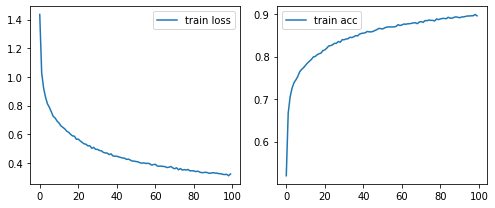

In [ ]:
loss = model_2_updated.history.history['loss']
acc = model_2_updated.history.history['accuracy']

plot_graph(loss,acc,epochs=100)

In [ ]:
model_2_updated.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 5s 3ms/step - loss: 0.5451 - accuracy: 0.8785


[0.5451216101646423, 0.8784999847412109]

If we recall, the model_2 gave **loss: 0.5276 and accuracy: 0.8775 on test set** and **loss: 0.3173 and accuracy: 0.8966 on the training set.**<br> The results are more or less same for model_2_updated.<br><br> **Lets see how we can further improve the model:**<br> It is often suggested to use batch normalisation at every layer, especially when the network runs deep. Empirically it is seen that including batchnorm at every layer has lead to huge improvements in the networks by reducing the vanishing gradients problem. The only downside is that it slightly increases training time because of the extra computations required at each layer. Also it acts a bit of a regularizer. Therefore in the 3rd model we will add batch normalization layer after every hidden layer (before activation layer). Take note that we already have batch normalization layer at the input but now we will put it across our whole network (but not output layer)

In [ ]:
def model3(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False, ver_bose=True):

  model = tensorflow.keras.models.Sequential()

  #adding input layer with batch normalisation - with he_normal initialization
  model.add(tensorflow.keras.layers.BatchNormalization(input_shape=(1024,), gamma_initializer='he_normal', name="input_with_batchnorm_layer"))

  #adding 1st layer with he_normal initialization
  model.add(Dense(700, name="h1_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 2nd layer with he_normal initialization
  model.add(Dense(700, name="h2_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 3rd layer with he_normal initialization
  model.add(Dense(700, name="h3_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 4th layer with he_normal initialization
  model.add(Dense(700, name="h4_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, kernel_initializer='he_normal', name="output_layer_softmax", kernel_regularizer=regularizers.l2(l2_lambda)))
  model.add(Activation('softmax'))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
  else:
    val=None
  
  if(ver_bose!=True):
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, verbose=0)
    print("model has been fitted.. evaluating on train and test set")
    score_train = model.evaluate(xtrain, ytrain, batch_size=32, verbose=0)
    score_test = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")

    return [model,score_train,score_test]
  else:
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, verbose=1)
    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
    
    return model



In [ ]:
model_3 = model3(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=10, learn_rate=1e-4, l2_lambda=1e-6, save_model_name="model_3")

Epoch 1/100
4200/4200 [==============================] - 36s 9ms/step - loss: 1.6598 - accuracy: 0.4401
Epoch 2/100
4200/4200 [==============================] - 36s 9ms/step - loss: 1.2295 - accuracy: 0.6026
Epoch 3/100
4200/4200 [==============================] - 36s 9ms/step - loss: 1.0849 - accuracy: 0.6529
Epoch 4/100
4200/4200 [==============================] - 36s 9ms/step - loss: 1.0029 - accuracy: 0.6798
Epoch 5/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.9435 - accuracy: 0.7006
Epoch 6/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.8987 - accuracy: 0.7139
Epoch 7/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.8644 - accuracy: 0.7240
Epoch 8/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.8340 - accuracy: 0.7351
Epoch 9/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.8099 - accuracy: 0.7427
Epoch 10/100
4200/4200 [==============================] - 36s 9m

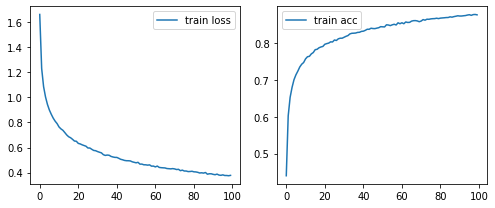

In [ ]:
loss = model_3.history.history['loss']
acc = model_3.history.history['accuracy']

plot_graph(loss,acc,epochs=100)

In [ ]:
model_3.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 6s 3ms/step - loss: 0.4701 - accuracy: 0.8799


[0.47012558579444885, 0.8799444437026978]

As expected batch normalization brings slight improvement to the results. The accuracy went up to 0.8799 from 0.8785 (model_2_updated) and loss went down to 0.4701 from 0.5451 (model_2_updated)<br><br>
Untill now we have trained all our models for 100 epochs only, it's high time that we increase the training process. We have saved this model and will fetch it and start training for another 100 epochs to see if we can improve the performance even further. The model is already trained for 100 epochs and will start training from where it left off.

In [ ]:
# loading old model
old_model3_1 = load_model("/content/drive/My Drive/Colab Notebooks/model_3.h5")

# training it for another 100 epochs
old_model3_1.fit(x_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3802 - accuracy: 0.8750
Epoch 2/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3688 - accuracy: 0.8808
Epoch 3/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3742 - accuracy: 0.8782
Epoch 4/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3629 - accuracy: 0.8807
Epoch 5/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3713 - accuracy: 0.8795
Epoch 6/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3642 - accuracy: 0.8810
Epoch 7/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3628 - accuracy: 0.8836
Epoch 8/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3540 - accuracy: 0.8844
Epoch 9/100
4200/4200 [==============================] - 36s 9ms/step - loss: 0.3633 - accuracy: 0.8832
Epoch 10/100
4200/4200 [==============================] - 36s 9m

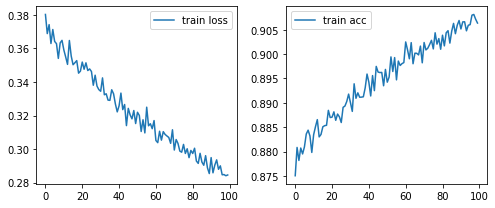

In [ ]:
# saving the extended model
old_model3_1.save("/content/drive/My Drive/Colab Notebooks/model_3_extended200.h5")


#plotting accuracy and loss for the extended model
loss = old_model3_1.history.history['loss']
acc = old_model3_1.history.history['accuracy']

plot_graph(loss,acc,epochs=100)

In [ ]:
# evaluating on the test set
old_model3_1.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 6s 3ms/step - loss: 0.5127 - accuracy: 0.8789


[0.5126889944076538, 0.878944456577301]

Even after training on 200 epochs the validation accuracy doesnt seem to be improving. It seems we need to have longer training sessions. But before that it also seems that the model architecture is still weak. We need a more complex and deep architecture. We will decide the architecture from the following anology.<br><br>
**Making it deep:**<br>
Adding more hidden layers allows the network to compute more complex features. It has been shown that the first few layers represent "simpler" features while the last layers represent more "complex" features. We typically go deep if the data is very unstructured (like an image) and needs to be processed quite a bit before useful information can be extracted from it.<br><br>
**Making it wider**:<br>
While going "deeper" means creating more complex features...going "wider" means creating more of these features. Eg: a model can be explained by very simple features(shallow model) but there needs to be many of these features(wider). Empirically it has been found that the layers become narrower towards the end of the network because the complex features(end layers) carry more information than simpler ones(starting layers) and thus you dont need a lot of them. Hence, it makes sense that the starting layers have more neurons than the ending layers simply because starting layers are simpler and might require more neurons to process the information.<br><br> For us, the images are indeed complex and thus we would need our model to compute more complex features. Having said that we will make the model more complex by adding 2 more layers making a total of 6 layers. Also, we had just 700 neurons in each layer untill now. We will increase the number of neurons as well.<br>We have 1024 input neurons which is a quite large number of feature set. Hence we will start with 900 neurons in the 1st hidden layer. Decrease it by 100 (i.e 800) in the 2nd hidden layer. Then we will decrease it again by 100 (i.e 700) and keep it that way for 3rd and 4th layer. For 5th layer we will decrease it by 50 (i.e 650) and finally for the 6th layer we will further decrease by 50 and use 600 neurons in the this layer.<br>**Take note that other than this all the things remain same. We still have he_normal initialization, relu activation after each layer (softmax after output layer) and batchnorm layer after each layer (before activation relu).** 

In [ ]:
def model4(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False, ver_bose=True):

  model = tensorflow.keras.models.Sequential()

  #adding input layer with batch normalisation - with he_normal initialization
  model.add(tensorflow.keras.layers.BatchNormalization(input_shape=(1024,), gamma_initializer='he_normal', name="input_with_batchnorm_layer"))

  #adding 1st layer with he_normal initialization
  model.add(Dense(900, name="h1_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 2nd layer with he_normal initialization
  model.add(Dense(800, name="h2_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 3rd layer with he_normal initialization
  model.add(Dense(700, name="h3_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 4th layer with he_normal initialization
  model.add(Dense(700, name="h4_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 5th layer with he_normal initialization
  model.add(Dense(650, name="h5_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 6th layer with he_normal initialization
  model.add(Dense(600, name="h6_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, kernel_initializer='he_normal', name="output_layer_softmax", kernel_regularizer=regularizers.l2(l2_lambda)))
  model.add(Activation('softmax'))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
    val_batch = 10
  else:
    val=None
    val_batch = None
  
  if(ver_bose!=True):
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, validation_batch_size=val_batch, verbose=0)
    print("model has been fitted.. evaluating on train and test set")
    score_train = model.evaluate(xtrain, ytrain, batch_size=32, verbose=0)
    score_test = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")

    return [model,score_train,score_test]
  else:
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, validation_batch_size=val_batch, verbose=1)
    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
    
    return model



In [ ]:
model_4 = model4(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=10, learn_rate=1e-4, l2_lambda=1e-6, save_model_name="model_4")

Epoch 1/100
4200/4200 [==============================] - 20s 5ms/step - loss: 1.8033 - accuracy: 0.3832
Epoch 2/100
4200/4200 [==============================] - 19s 5ms/step - loss: 1.3433 - accuracy: 0.5603
Epoch 3/100
4200/4200 [==============================] - 19s 5ms/step - loss: 1.1723 - accuracy: 0.6240
Epoch 4/100
4200/4200 [==============================] - 19s 5ms/step - loss: 1.0709 - accuracy: 0.6571
Epoch 5/100
4200/4200 [==============================] - 19s 5ms/step - loss: 1.0023 - accuracy: 0.6818
Epoch 6/100
4200/4200 [==============================] - 19s 5ms/step - loss: 0.9529 - accuracy: 0.6959
Epoch 7/100
4200/4200 [==============================] - 19s 5ms/step - loss: 0.9172 - accuracy: 0.7053
Epoch 8/100
4200/4200 [==============================] - 19s 5ms/step - loss: 0.8842 - accuracy: 0.7204
Epoch 9/100
4200/4200 [==============================] - 20s 5ms/step - loss: 0.8435 - accuracy: 0.7310
Epoch 10/100
4200/4200 [==============================] - 19s 5m

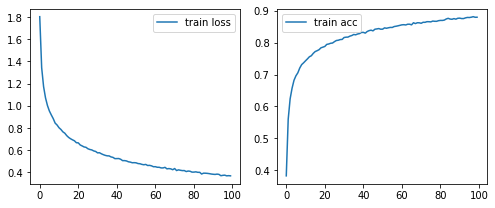

In [ ]:
loss = model_4.history.history['loss']
acc = model_4.history.history['accuracy']

plot_graph(loss,acc,epochs=100)

In [ ]:
model_4.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 4s 2ms/step - loss: 0.5044 - accuracy: 0.8810


[0.5044280290603638, 0.8809999823570251]

The validation accuracy improved **from 0.8789 to 0.8810** which is negligible. It clearly seems that we need to train for a large number of epochs for our model to work. Hence we will go for longer training session in an attempt to to minimize the loss and improve the accuracy even further on both training set and test set. We have been training for only 100 epochs untill now and not giving our model the chance to learn much. **We could use the 4 layer architecture instead of 6 layer architecture since there is not much difference in terms of performance but still we will go with the bigger network since it is more likely to give better performace. If it overfits, we can just as easily prune the model with early stopping and other regularisation techniques like dropouts.**<br>
- We will now train the model for 1000 epochs and use early stopping to avoid over fitting. Also we will train on smaller batches so as to improve the training time.
- We will also add dropout layers to the existing model. Since we are training with a large number of epochs our training is most likely to overfit the dataset. Dropouts acts as a regularizer by providing ensemble modelling. For every epoch we randomly drop a few neurons. Due to this random dropping of neurons our model architecture changes with every epoch.
- Also we will monitor the training accuracy and stop the training when it will saturate. We will make use of early stopping callback for the purpose.
- Lastly, we will make use of ReduceLROnPlateau callback. It is often seen that models benefit from reducing the learning rate once learning process stagnates. We will start with learning rate of 1e-4 (which we found from tuning) and once the learning stagnates, we will reduce it by a factor of 0.1 (reduce by 10%) to 1e-5. **Learning rate is changed by this formula: New_lr = current_lr * factor**

In [ ]:
def model5(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False):

  model = tensorflow.keras.models.Sequential()

  #adding input layer with batch normalisation - with he_normal initialization
  model.add(tensorflow.keras.layers.BatchNormalization(input_shape=(1024,), gamma_initializer='he_normal', name="input_with_batchnorm_layer"))

  #adding 1st layer with he_normal initialization
  model.add(Dense(900, name="h1", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #adding 2nd layer with he_normal initialization
  model.add(Dense(800, name="h2", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #adding 3rd layer with he_normal initialization
  model.add(Dense(700, name="h3", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #adding 4th layer with he_normal initialization
  model.add(Dense(700, name="h4", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #adding 5th layer with he_normal initialization
  model.add(Dense(650, name="h5", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #adding 6th layer with he_normal initialization
  model.add(Dense(600, name="h6", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, kernel_initializer='he_normal', name="output_layer", kernel_regularizer=regularizers.l2(l2_lambda)))
  model.add(Activation('softmax'))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
    val_batch = 10
  else:
    val=None
    val_batch = None


  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=70, verbose=1, mode='min', restore_best_weights=True)
  change_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=150, verbose=1, mode='max', min_delta=0.01, cooldown=70, min_lr=0.000001)
  model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, validation_batch_size=val_batch, callbacks=[early_stop,change_lr], verbose=1)
  
  if(save_model_name!=False):
    model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
    
  return model



**Early stopping:**<br>
monitor='loss'<br> 
min_delta=0.01<br>
patience=70<br>
verbose=1<br>
mode='min'<br>
restore_best_weights=True<br>
**We are monitoring training loss. If the loss does not decrease (mode="min"; since we want to minimize the loss) by 0.01 (min_delta) or more it will wait for 70 epochs (patience) and then stop the training there only, restoring the weights of the best epoch among all other epochs untill the epoch where the training halted (restore_best_weights=True).**

<br>

**ReduceLROnPlateau:**<br>
monitor='val_accuracy'<br>
factor=0.1<br>
patience=150<br>
verbose=1<br>
mode='max'<br>
min_delta=0.01<br>
cooldown=70<br>
min_lr=0.000001<br>
**Here we are monitoring test accuracy. If the accuracy does not increase (mode="max"; since we want to maximize the accuracy) by 0.01 (min_delta) or more it will wait for 150 epochs (patience) and then drop the learning rate by a factor of 0.1 (factor). After the learning rate is changed, it will wait for 70 more epochs (cooldown) before starting to monitor the test accuracy again. It will not decrease learning rate if it reaches 1e-6 (min_lr).**

In [ ]:
model_5 = model5(xtrain=x_train, ytrain=y_train, epoch=1000, batchsize=32, learn_rate=1e-4, l2_lambda=1e-6, validate=True, save_model_name="model_5")

Epoch 1/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 2.2530 - accuracy: 0.2124 - val_loss: 1.4177 - val_accuracy: 0.5268
Epoch 2/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 1.5508 - accuracy: 0.4684 - val_loss: 0.9647 - val_accuracy: 0.6925
Epoch 3/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 1.2330 - accuracy: 0.5927 - val_loss: 0.8303 - val_accuracy: 0.7391
Epoch 4/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 1.0766 - accuracy: 0.6546 - val_loss: 0.7271 - val_accuracy: 0.7721
Epoch 5/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 0.9872 - accuracy: 0.6839 - val_loss: 0.6570 - val_accuracy: 0.7956
Epoch 6/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 0.9098 - accuracy: 0.7085 - val_loss: 0.6205 - val_accuracy: 0.8083
Epoch 7/1000
1313/1313 [==============================] - 24s 18ms/step - loss: 0.8510 - accuracy: 0.7270 - val_

In [ ]:
hist_df = pd.DataFrame(model_5.history.history) 
hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/model_5_history.csv',index=False)

In [ ]:
model_5 = load_model("/content/drive/My Drive/Colab Notebooks/model_5.h5")
hist_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/model_5_history.csv')

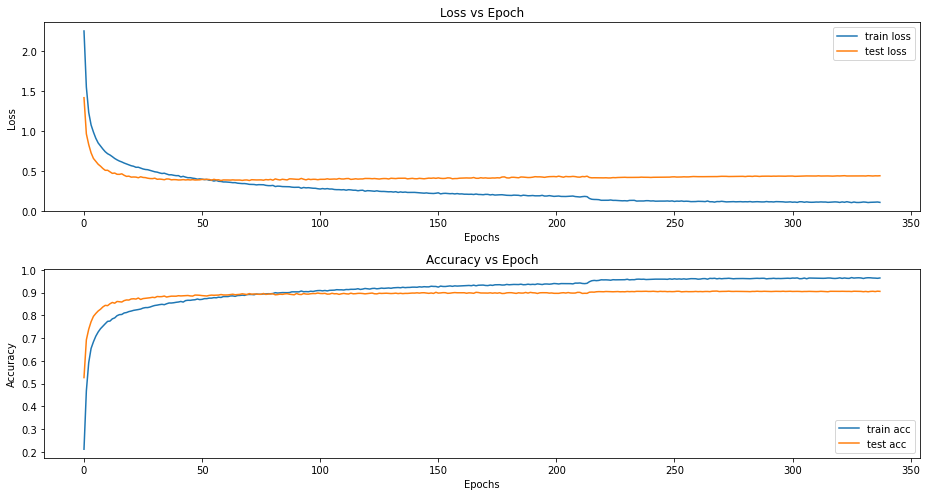

In [ ]:
loss = hist_df['loss']
acc = hist_df['accuracy']
val_loss = hist_df['val_loss']
val_acc = hist_df['val_accuracy']
epoch = hist_df.shape[0]

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))

axes[0].plot(range(0,epoch), loss, label="train loss")
axes[0].plot(range(0,epoch), val_loss, label="test loss")
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(0,epoch), acc, label="train acc")
axes[1].plot(range(0,epoch), val_acc, label="test acc")
axes[1].set_title("Accuracy vs Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

figure.show()
plt.tight_layout()

We planned for longer training session of 1000 epochs but with callback methods like early stopping and reducing learning rate we completed the training in 338 epochs only thereby saving us a lot of resources and time.<br>
**The learning rate decreased only 1 time before early stopping stopped the training. It was decreased from 1e-4 to 1e-5 at 214th epoch which is evident from the training process above. See below:** 

0.00010    214
0.00001    124
Name: lr, dtype: int64



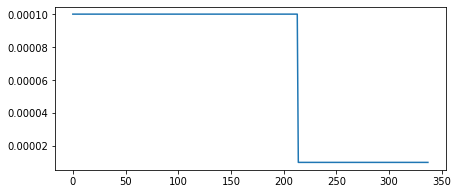

In [ ]:
print(hist_df["lr"].value_counts())
print("")

plt.figure(figsize=(7, 3))
plt.plot(range(0,epoch), hist_df["lr"])
plt.show()

In [ ]:
model_5.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 8s 5ms/step - loss: 0.4300 - accuracy: 0.9062


[0.43002769351005554, 0.906166672706604]

There is a significant improvement in training as well as testing scores. After proper training and dropout layers we were able to bring the **loss to 0.4300 from 0.5044** and **accuracy to 0.9062 from 0.8810** (TESTING SCORES) and **loss to 0.1070 from 0.3681** and **accuracy to 0.9641 from 0.8791** (TRAINING SCORES)<br>
### lets see the confusion matrix and classification report of the test set:

In [ ]:
y_pred = np.argmax(model_5.predict(x_test), axis=1)
y_true = np.argmax(y_test,axis=1)

print("CLASSIFICATION REPORT")
print(classification_report(y_true=y_true, y_pred=y_pred))
print("")

print("CONFUSION MATRIX")
mat_train = confusion_matrix(y_true,y_pred)
idx=range(10)
df_cm = pd.DataFrame(mat_train, index=["truth "+str(i) for i in idx], columns=["predicted "+str(i) for i in idx])
df_cm

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1814
           1       0.88      0.91      0.89      1828
           2       0.94      0.91      0.92      1803
           3       0.88      0.87      0.88      1719
           4       0.92      0.93      0.93      1812
           5       0.90      0.90      0.90      1768
           6       0.91      0.89      0.90      1832
           7       0.92      0.93      0.92      1808
           8       0.91      0.89      0.90      1812
           9       0.90      0.89      0.90      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000


CONFUSION MATRIX


,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7,predicted 8,predicted 9
truth 0,1706,33,4,6,12,2,10,12,8,21
truth 1,24,1671,12,18,34,7,9,31,11,11
truth 2,12,18,1640,20,17,9,3,37,16,31
truth 3,15,23,20,1497,13,65,16,20,27,23
truth 4,15,40,11,13,1687,8,10,6,6,16
truth 5,12,11,10,54,9,1584,46,4,23,15
truth 6,32,17,7,16,23,46,1633,7,37,14
truth 7,14,54,19,11,10,6,3,1676,4,11
truth 8,19,22,13,34,12,16,50,7,1607,32
truth 9,50,19,13,23,13,22,11,17,26,1610


### We also have a validation set with 60000 images. Lets evaluate our model on the validation set

In [ ]:
xval = df['X_val'][:]
yval = df['y_val'][:]
x_val = xval.reshape(60000, 1024)
y_val = to_categorical(yval, num_classes=10)

model_5.evaluate(x_val,y_val,batch_size=10)

6000/6000 [==============================] - 28s 5ms/step - loss: 0.1398 - accuracy: 0.9699


[0.13979431986808777, 0.9699166417121887]

**Accuracy of ~ 97% on the validation set.** Lets see the confusion matrix and classification report

In [ ]:
y_pred = np.argmax(model_5.predict(x_val), axis=1)
y_true = np.argmax(y_val,axis=1)

print("CLASSIFICATION REPORT")
print(classification_report(y_true=y_true, y_pred=y_pred))
print("")

print("CONFUSION MATRIX")
mat_train = confusion_matrix(y_true,y_pred)
idx=range(10)
df_cm = pd.DataFrame(mat_train, index=["truth "+str(i) for i in idx], columns=["predicted "+str(i) for i in idx])
df_cm

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6000
           1       0.95      0.97      0.96      6000
           2       0.98      0.97      0.98      6000
           3       0.96      0.96      0.96      6000
           4       0.98      0.98      0.98      6000
           5       0.97      0.97      0.97      6000
           6       0.97      0.96      0.97      6000
           7       0.97      0.98      0.98      6000
           8       0.97      0.96      0.97      6000
           9       0.97      0.97      0.97      6000

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000


CONFUSION MATRIX


,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7,predicted 8,predicted 9
truth 0,5886,35,4,7,12,2,10,14,8,22
truth 1,24,5841,12,20,34,7,9,31,11,11
truth 2,13,23,5826,22,17,10,3,38,17,31
truth 3,16,29,21,5766,13,66,16,23,27,23
truth 4,16,49,11,14,5863,8,10,7,6,16
truth 5,13,14,10,64,9,5799,47,6,23,15
truth 6,32,21,8,18,23,46,5788,7,43,14
truth 7,14,57,19,11,12,6,3,5863,4,11
truth 8,23,28,13,37,13,17,56,8,5772,33
truth 9,55,20,16,27,14,22,11,18,26,5791


# We chose this to be our final neural network.

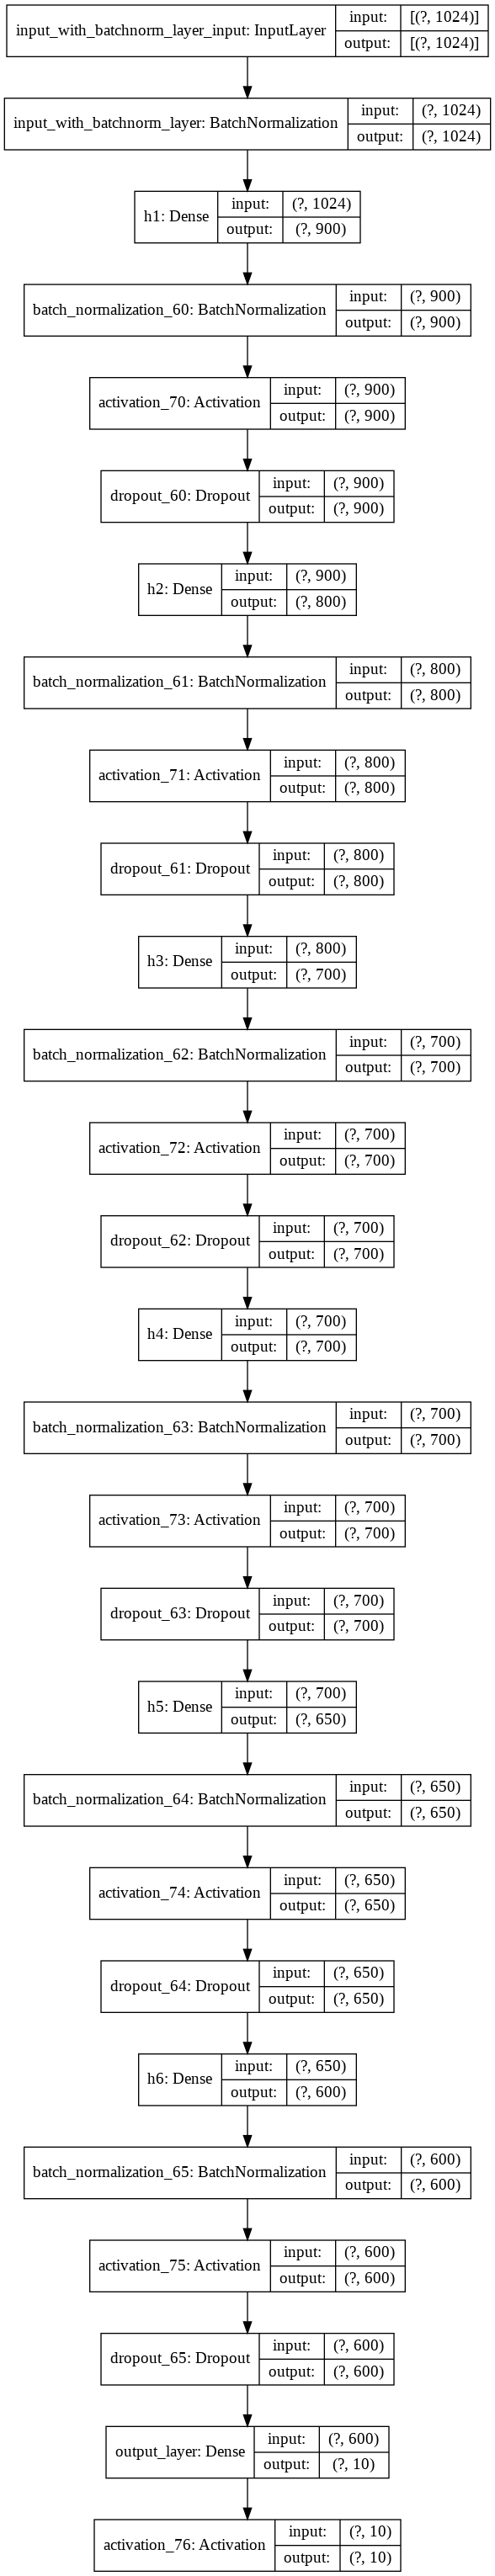

In [ ]:
plot_model(model_5, show_shapes=True, show_layer_names=True)

# In the next part we will train a Convolutional Neural Network. With CNN we wont have to make a 6 layer fully connected architecture. The classifier part of the CNN would be much simpler than this.